# Import libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.display import Image

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dropout, Concatenate, Add
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import img_to_array, load_img
from keras import backend as K
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

# Set up data dirs

In [2]:
TEST_DIR = './data/test'
TRAIN_DIR = './data/train'

def setup_data(type):
    """
    Set up working dirs
    
    """
    if type == 'train':
        os.makedirs(TRAIN_DIR, exist_ok=True)
        os.system(f'cp ../input/tgs-salt-identification-challenge/train.csv {TRAIN_DIR}')
        os.system(f'unzip -qq ../input/tgs-salt-identification-challenge/train.zip -d {TRAIN_DIR}')
        print(f'Set up {TRAIN_DIR}')
    elif type == 'test':
        os.makedirs(TEST_DIR, exist_ok=True)
        os.system(f'unzip -qq ../input/tgs-salt-identification-challenge/test.zip -d {TEST_DIR}')
        print(f'Set up {TEST_DIR}')
    else:
        print(f'Type {type} not supported (train|test)')
        
setup_data('train')
setup_data('test')

Set up ./data/train
Set up ./data/test


In [3]:
# Get list of training images
train_imgs_path = './data/train/images'
train_masks_path = './data/train/masks'
train_imgs = os.listdir(train_imgs_path)
print('Number of train images:', len(train_imgs))

train_masks = os.listdir(train_masks_path)

# Get list of test images
test_imgs_path = './data/test/images'
print('Number of test images:', len(os.listdir(test_imgs_path)))

Number of train images: 4000
Number of test images: 18000


# Split training and validation set
We split data by coverage ratio of salt 

In [4]:
def get_coverage_level(mask):
    return np.sum(mask) / (img_height * img_width)

def map_to_class(cover):
    if cover == 0.0:
        return 0
    elif 0.0 < cover <= 0.05: # equivalent to ~500 masked pixels
        return 1
    elif  0.05 < cover <= 0.3:
        return 2
    elif 0.3 < cover <= 0.5:
        return 3
    elif 0.5 < cover <= 0.8:
        return 4
    elif 0.8 < cover <= 1.0:
        return 5
    else:
        raise ValueError(f'Mask has inappropriate pixel value: {cover}')

In [5]:
# Image dimension
img_height = 128
img_width = 128

# Set up X and y
X = np.zeros((len(train_imgs), img_height, img_width, 1), dtype=np.float32)
y = np.zeros((len(train_masks), img_height, img_width, 1), dtype=np.float32)

# Load imgs
for idx, img_path in enumerate(train_imgs):
    img = load_img(train_imgs_path + '/' + img_path, color_mode='grayscale', target_size=(img_height, img_width, 1))
    X[idx] = img_to_array(img) / 255.0
    
coverage = np.array([])            # coverage ratio
coverage_class = np.array([])      # equivalent coverage class
# Load masks
for idx, mask_path in enumerate(train_masks):
    mask = load_img(train_masks_path + '/' + mask_path, color_mode='grayscale', target_size=(img_height, img_width, 1))
    y[idx] = img_to_array(mask) / 65535.0
    # Save coverage
    cover = get_coverage_level(y[idx])
    coverage = np.append(coverage, cover)
    coverage_class = np.append(coverage_class, map_to_class(cover))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Coverage class')

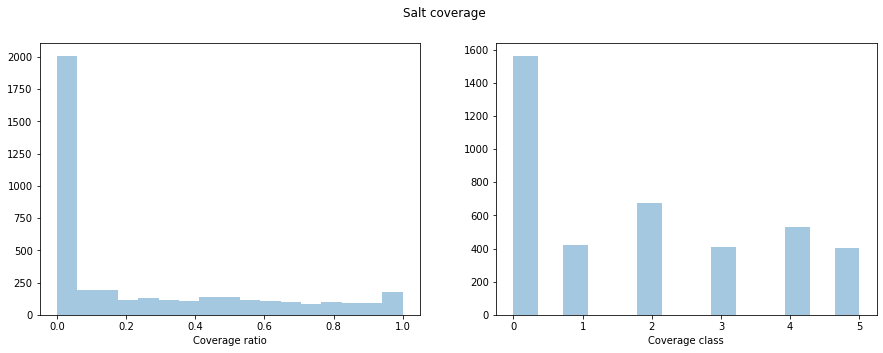

In [6]:
# Plot salt coverage ratio and coverage class
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(coverage, kde=False, ax=axs[0])
sns.distplot(coverage_class, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage ratio")
axs[1].set_xlabel("Coverage class")

In [7]:
# Split train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=coverage_class, random_state=0)
print('Number of training imgs:', len(X_train))
print('Number of validation imgs:', len(X_val))

Number of training imgs: 3200
Number of validation imgs: 800


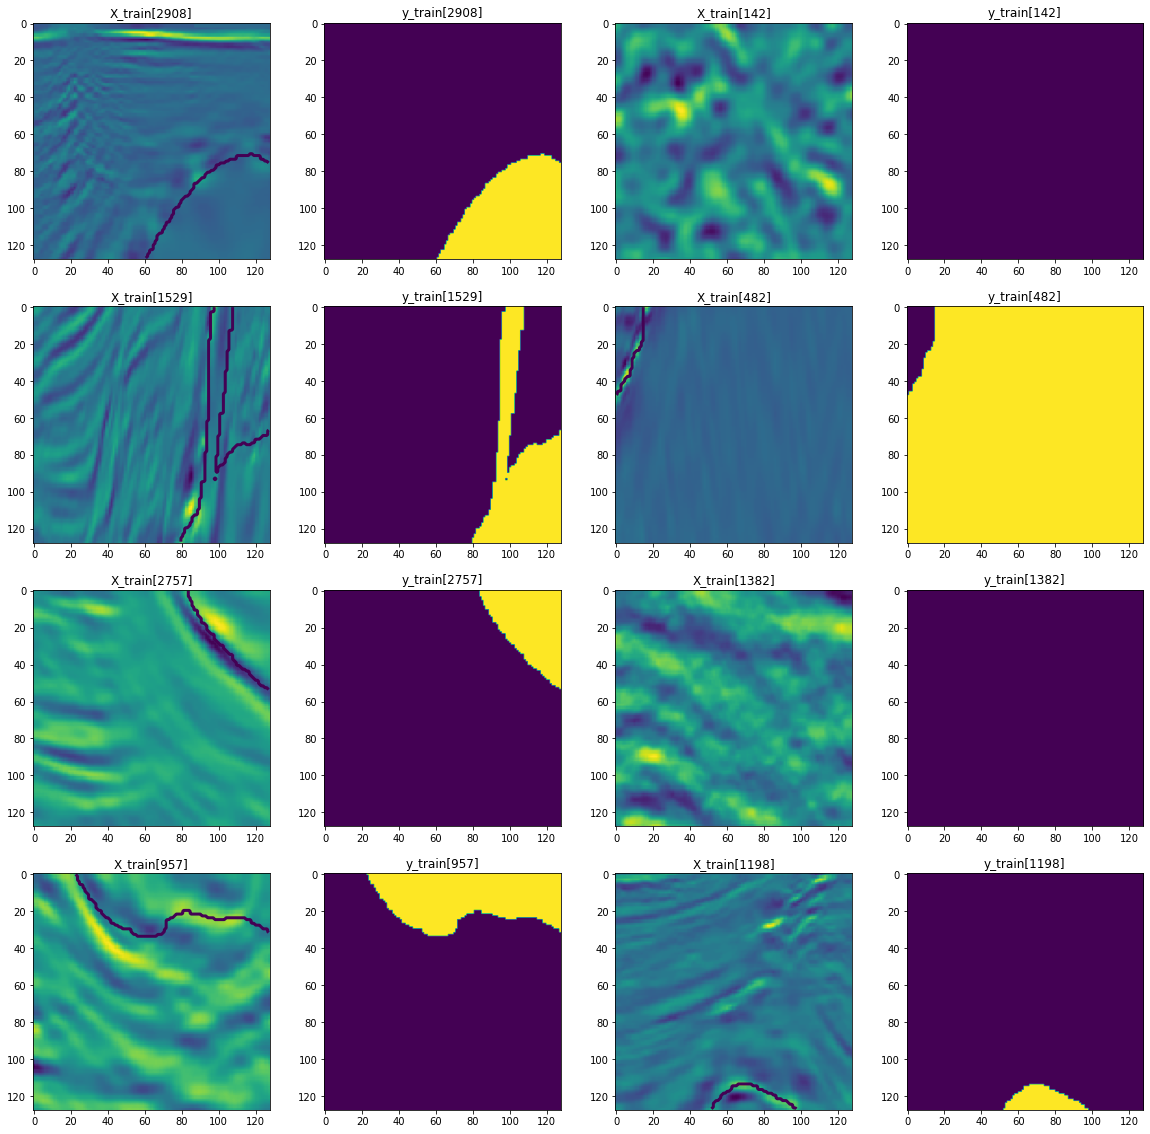

In [8]:
# See some examples
fig = plt.figure(figsize=(20, 20))
for i in range(1, 17, 2):
    idx = random.randint(0, len(X_train))
    has_mask = y_train[idx].max() > 0
    ax1 = plt.subplot(4, 4, i)
    ax1.imshow(X_train[idx])
    if has_mask:
        ax1.contour(y_train[idx].squeeze(), linewidths=3, levels=[0.5])
    ax1.set_title(f'X_train[{idx}]')
    ax2 = plt.subplot(4, 4, i + 1)
    ax2.imshow(y_train[idx])
    ax2.set_title(f'y_train[{idx}]')

# Augmentation

In [9]:
# def augment(X, y):
#     idx = 0
#     limit = len(X)
#     while idx < limit: 
#         prob = tf.random.uniform([], dtype=tf.float32).numpy()
#         len_aug = tf.random.uniform([], minval=1, maxval=400, dtype=tf.int32).numpy()
#         if len_aug > limit - idx:
#             len_aug = limit - idx
#         if 0 <= prob < 0.25:
#             X = np.append(X, [np.fliplr(x) for x in X[idx:len_aug+idx]], axis=0)
#             y = np.append(y, [np.fliplr(x) for x in y[idx:len_aug+idx]], axis=0)
#         elif 0.25 <= prob < 0.5:
#             X = np.append(X, [np.flipud(x) for x in X[idx:len_aug+idx]], axis=0)
#             y = np.append(y, [np.flipud(x) for x in y[idx:len_aug+idx]], axis=0) 
#         elif 0.5 <= prob < 0.75:
#             X = np.append(X, [np.expand_dims(np.transpose(np.squeeze(x)), axis=-1) for x in X[idx:len_aug+idx]], axis=0)
#             y = np.append(y, [np.expand_dims(np.transpose(np.squeeze(x)), axis=-1) for x in y[idx:len_aug+idx]], axis=0) 
#         elif 0.75 <= prob <= 1:
#             X = np.append(X, [np.rot90(x) for x in X[idx:len_aug+idx]], axis=0)
#             y = np.append(y, [np.rot90(x) for x in y[idx:len_aug+idx]], axis=0)
#         else:
#             raise ValueError('prob is not valid')
#         idx += len_aug
        
#     return X, y
    
# X_train, y_train = augment(X_train, y_train)

X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [10]:
print('Training images after augmentation:', X_train.shape)
print('Training masks after augmentation:', X_train.shape)

Training images after augmentation: (6400, 128, 128, 1)
Training masks after augmentation: (6400, 128, 128, 1)


# Loss
We define Lovasz loss function

In [11]:
# Credit: https://github.com/bermanmaxim/LovaszSoftmax/blob/master/tensorflow/lovasz_losses_tf.py  
# Edited for competible with Tensorflow 2
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   name="loss")
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image=True, ignore=None)
    return loss

# Metrics
We define [mean IoU](https://www.kaggle.com/c/tgs-salt-identification-challenge/overview/evaluation) (competition's evaluation method) metrics here. 

In [12]:
# Credit: https://www.kaggle.com/donchuk/fast-implementation-of-scoring-metric/script
# Edited for competible with Tensorflow 2
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)


def mean_iou(label, pred):
    return tf.numpy_function(get_iou_vector, [label, pred>0.5], tf.float64)


def mean_iou_2(label, pred):
    return tf.numpy_function(get_iou_vector, [label, pred>0], tf.float64)

# U-net Resnet based model

In [13]:
def batch_activation(input_tensor):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    return x


def residual_blocks(input_tensor, filters, has_batch_activation=False):
    x = batch_activation(input_tensor)
    x = Conv2D(filters, 3, kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = Conv2D(filters, 3, kernel_initializer='he_normal', padding='same')(x)
    x = Add()([x, input_tensor])
    if has_batch_activation:
        x = batch_activation(x)
    
    return x

In [14]:
def build_Resnet_Unet(inputs, kernel_size=(3, 3), num_filters=16, dropout_rate=0.5):
    def encoder_blocks(input_tensor, filters, kernel_shape=kernel_size):
        """
        Encoder blocks for Res-Unet
        """
        x = Conv2D(filters, kernel_shape, padding='same')(input_tensor)
        x = residual_blocks(x, filters)
        x = residual_blocks(x, filters, True)

        return x
    
    def decoder_blocks(input_tensor, filters, do_rate, kernel_shape=kernel_size):
        """
        Decoder blocks for Res-Unet
        """
        x = Dropout(do_rate)(input_tensor)
        x = Conv2D(filters, kernel_shape, padding='same')(x)
        x = residual_blocks(x, filters)
        x = residual_blocks(x, filters, True)
        
        return x

    
    # Encoder
    e1 = encoder_blocks(inputs, filters=num_filters)
    x = MaxPooling2D(pool_size=(2, 2))(e1)
    x = Dropout(dropout_rate / 2)(x)
    
    e2 = encoder_blocks(x, filters=num_filters * 2)
    x = MaxPooling2D(pool_size=(2, 2))(e2)
    x = Dropout(dropout_rate)(x)
    
    e3 = encoder_blocks(x, filters=num_filters * 4)
    x = MaxPooling2D(pool_size=(2, 2))(e3)
    x = Dropout(dropout_rate)(x)
    
    e4 = encoder_blocks(x, filters=num_filters * 8)
    x = MaxPooling2D(pool_size=(2, 2))(e4)
    x = Dropout(dropout_rate)(x)
    
    # Middle
    m = Conv2D(num_filters * 16, kernel_size, padding='same')(x)
    m = residual_blocks(m, num_filters * 16)
    m = residual_blocks(m, num_filters * 16, True)
    
    # Decoder
    d4 = Conv2DTranspose(num_filters * 8, kernel_size, strides=(2, 2), padding='same')(m)
    x = Concatenate()([d4, e4])
    x = decoder_blocks(x, num_filters * 8, dropout_rate)
    
    d3 = Conv2DTranspose(num_filters * 4, kernel_size, strides=(2, 2), padding='same')(x)
    x = Concatenate()([d3, e3])
    x = decoder_blocks(x, num_filters * 4, dropout_rate)
    
    d2 = Conv2DTranspose(num_filters * 4, kernel_size, strides=(2, 2), padding='same')(x)
    x = Concatenate()([d2, e2])
    x = decoder_blocks(x, num_filters * 2, dropout_rate)
    
    d1 = Conv2DTranspose(num_filters, kernel_size, strides=(2, 2), padding='same')(x)
    x = Concatenate()([d1, e1])
    x = decoder_blocks(x, num_filters, dropout_rate)
    
    x = Conv2D(1, 1, padding='same', activation=None)(x)
    output = Activation('sigmoid')(x)
    
    return output, x

In [15]:
def create_model(inputs,
                 outputs,
                 optimizers_used, 
                 loss_used='bce',
                 lr=0.01,
                 save_model_name='best_model.h5', 
                 min_lr=0.0001, 
                 factor=0.5):
        
    model = Model(inputs=[inputs], outputs=[outputs])
    
    # Set up optimizers
    if optimizers_used == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizers_used == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    else:
        raise ValueError('Optimizer not implemented!')
    
    # Set up callbacks
    if loss_used == 'lovasz':
        checkpoint = ModelCheckpoint(save_model_name, monitor='val_mean_iou_2', verbose=1,
                             save_best_only=True, mode='max')
        rdlr = ReduceLROnPlateau(monitor='val_mean_iou_2', factor=factor, patience=6,
                                 min_lr=min_lr, verbose=1, mode='max')
    elif loss_used == 'bce':
        checkpoint = ModelCheckpoint(save_model_name, monitor='val_mean_iou', verbose=1,
                             save_best_only=True, mode='max')
        rdlr = ReduceLROnPlateau(monitor='val_mean_iou', factor=factor, patience=6,
                                 min_lr=min_lr, verbose=1, mode='max')
    else:
        raise ValueError('Loss not implemented!')
    
    callbacks = [checkpoint, rdlr]
    return model, callbacks, optimizer

In [16]:
inputs = Input(shape=(img_height, img_width, 1))
outputs, pre_output = build_Resnet_Unet(inputs=inputs)

model, callbacks, optimizer = create_model(inputs, 
                                           outputs, 
                                           optimizers_used='Adam', 
                                           loss_used='bce', 
                                           save_model_name='best_model_1.h5')
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[mean_iou])
# model.summary()

2022-01-14 15:02:00.256352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 15:02:00.428692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 15:02:00.429821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 15:02:00.431531: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=60, verbose=1,
                 callbacks=callbacks, validation_data=(X_val, y_val))

2022-01-14 15:02:06.125331: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-01-14 15:02:11.790209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 37s 122ms/step - loss: 0.4089 - mean_iou: 0.3515 - val_loss: 4.7394 - val_mean_iou: 0.2313

Epoch 00001: val_mean_iou improved from -inf to 0.23125, saving model to best_model_1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
200/200 [==============================] - 23s 117ms/step - loss: 0.3545 - mean_iou: 0.4466 - val_loss: 0.3824 - val_mean_iou: 0.5661

Epoch 00002: val_mean_iou improved from 0.23125 to 0.56612, saving model to best_model_1.h5
Epoch 3/60
200/200 [==============================] - 23s 117ms/step - loss: 0.2966 - mean_iou: 0.4938 - val_loss: 0.5459 - val_mean_iou: 0.2036

Epoch 00003: val_mean_iou did not improve from 0.56612
Epoch 4/60
200/200 [==============================] - 23s 117ms/step - loss: 0.2816 - mean_iou: 0.5137 - val_loss: 0.2676 - val_mean_iou: 0.5830

Epoch 00004: val_mean_iou improved from 0.56612 to 0.58300, saving model to best_model_1.h5
Epoch 5/60
200/200 [==============================] - 24s 118ms/step - loss: 0.2686 - mean_iou: 0.5362 - val_loss: 0.4997 - val_mean_iou: 0.3604

Epoch 00005: val_mean_iou did not improve from 0.58300
Epoch 6/60
200/200 [==============================] - 23s 117ms/step - loss: 0.2489 - mean_iou: 0.5639 - val_loss: 0.3115 

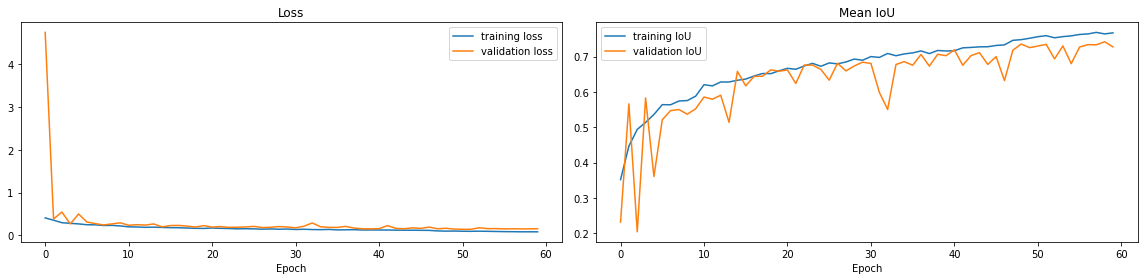

In [18]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Loss')
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(122)
plt.title('Mean IoU')
plt.plot(hist.history['mean_iou'], label='training IoU')
plt.plot(hist.history['val_mean_iou'], label='validation IoU')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
model1 = load_model('./best_model_1.h5', custom_objects={'mean_iou': mean_iou})

inputs2 = model1.layers[0].input
outputs2 = model1.layers[-1].input
model, callbacks, optimizer = create_model(inputs=inputs2, 
                                           outputs=outputs2, 
                                           optimizers_used='Adam', 
                                           loss_used='lovasz',
                                           save_model_name='best_model_2.h5')
model.compile(optimizer=optimizer, loss=lovasz_loss, metrics=[mean_iou_2])

In [20]:
history = model.fit(X_train, y_train, batch_size=32, epochs=40, verbose=1,
                     callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/40
200/200 [==============================] - 43s 190ms/step - loss: 0.4979 - mean_iou_2: 0.7422 - val_loss: 0.5729 - val_mean_iou_2: 0.6995

Epoch 00001: val_mean_iou_2 improved from -inf to 0.69950, saving model to best_model_2.h5
Epoch 2/40
200/200 [==============================] - 38s 191ms/step - loss: 0.4614 - mean_iou_2: 0.7442 - val_loss: 0.4803 - val_mean_iou_2: 0.7280

Epoch 00002: val_mean_iou_2 improved from 0.69950 to 0.72800, saving model to best_model_2.h5
Epoch 3/40
200/200 [==============================] - 36s 180ms/step - loss: 0.4630 - mean_iou_2: 0.7350 - val_loss: 0.6603 - val_mean_iou_2: 0.6476

Epoch 00003: val_mean_iou_2 did not improve from 0.72800
Epoch 4/40
200/200 [==============================] - 38s 192ms/step - loss: 0.4761 - mean_iou_2: 0.7334 - val_loss: 0.6283 - val_mean_iou_2: 0.6534

Epoch 00004: val_mean_iou_2 did not improve from 0.72800
Epoch 5/40
200/200 [==============================] - 37s 187ms/step - loss: 0.4684 - mean_iou_2: 0.7

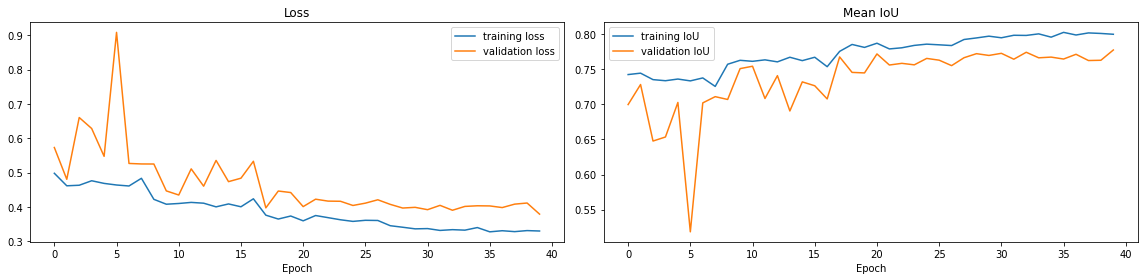

In [21]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(122)
plt.title('Mean IoU')
plt.plot(history.history['mean_iou_2'], label='training IoU')
plt.plot(history.history['val_mean_iou_2'], label='validation IoU')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Test

In [22]:
# Load model for final test
best_model = load_model('./best_model_2.h5', custom_objects={'mean_iou_2': mean_iou_2, 'lovasz_loss': lovasz_loss})

In [23]:
# Load test images
test_imgs_path = './data/test/images'
test_imgs = os.listdir(test_imgs_path)

X_test = np.zeros((len(test_imgs), img_height, img_width, 1), dtype=np.float32)
test_ids = []

# Load imgs
for idx, img_path in tqdm(enumerate(test_imgs)):
    img = load_img(test_imgs_path + '/' + img_path, color_mode='grayscale', target_size=(img_height, img_width, 1))
    X_test[idx] = img_to_array(img) / 255.0
    test_ids.append(img_path.split('.')[0])

0it [00:00, ?it/s]

In [24]:
# Predict 
preds_test = best_model.predict(X_test, verbose=1)
preds_val = best_model.predict(X_val, verbose=1)

preds_test_bin = (preds_test > 0.5).astype(np.uint8)
preds_val_bin = (preds_val > 0.5).astype(np.uint8)

2022-01-14 15:53:16.975502: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.
2022-01-14 15:53:18.161901: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.


563/563 [==============================] - 16s 26ms/step


2022-01-14 15:53:35.164697: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.


25/25 [==============================] - 1s 26ms/step


In [25]:
# IoU metric implementation for validation set check
# Credit: https://www.kaggle.com/aglotero/another-iou-metric
# Edited for personal uses
def iou_metric(labels, y_pred):
    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
    intersection = temp1[0]
    
    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    return iou

0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0, 0.5, 'IoU')

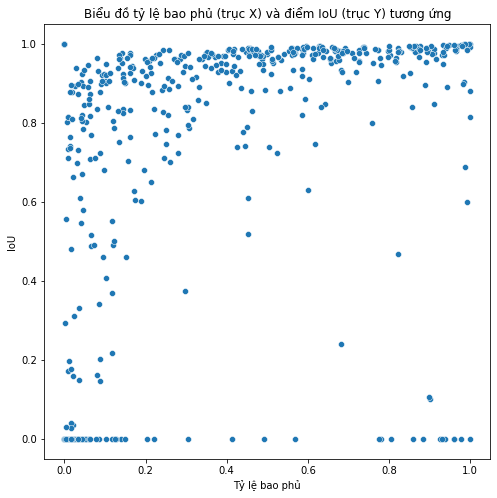

In [26]:
# Get IoU list and equivalent salt coverage list
iou_list = [np.asscalar(np.squeeze(iou_metric(y_true, y_pred))) for y_true, y_pred in tqdm(zip(y_val, preds_val_bin))]
coverage_list = [get_coverage_level(label) for label in y_val]

plt.figure(figsize=(8, 8))
sns.scatterplot(x=coverage_list, y=iou_list)
plt.title('Biểu đồ tỷ lệ bao phủ (trục X) và điểm IoU (trục Y) tương ứng')
plt.xlabel('Tỷ lệ bao phủ')
plt.ylabel('IoU')

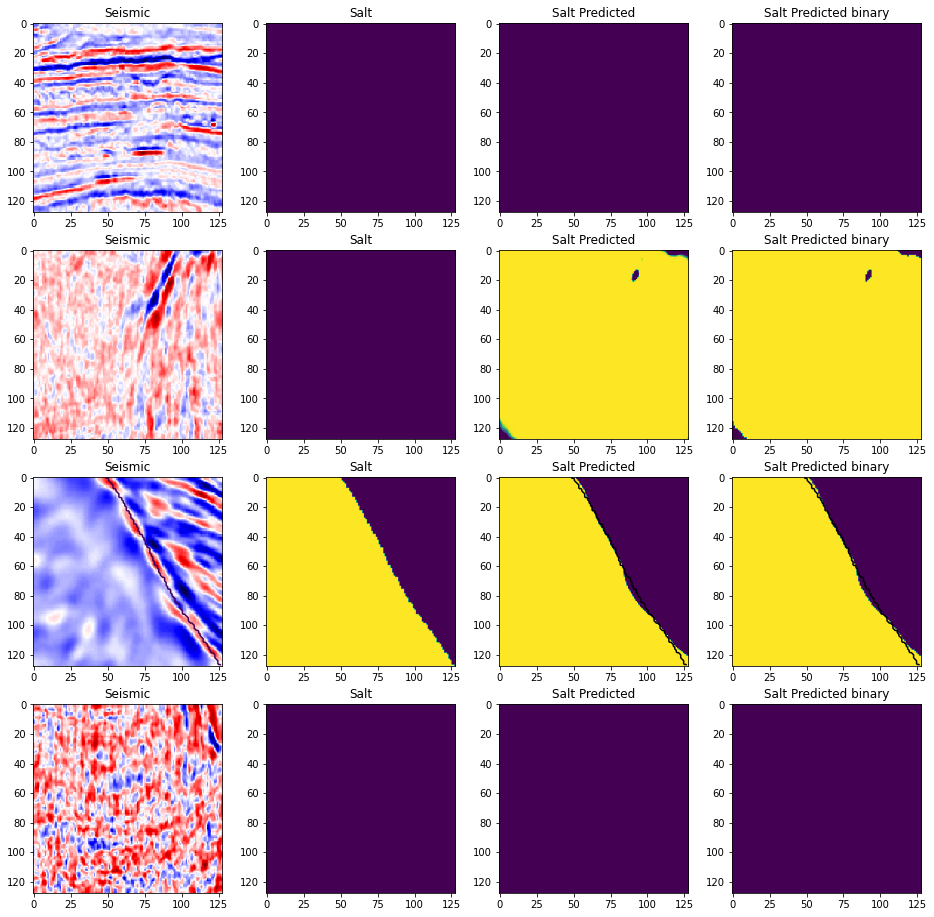

In [27]:
# Plot some predictions of validation set
def plot_sample(X, y, preds, binary_preds, n_rows, n_cols=4, known_idx=[]):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows), squeeze=False)
    for row in range(0, n_rows):
        for col in range(0, n_cols):
            ix = col % n_cols
            if ix == 0:
                # Get random image index
                if len(known_idx) > 0:
                    idx = random.randint(0, len(known_idx))
                else:
                    idx = random.randint(0, len(X))
                has_mask = y[idx].max() > 0

                ax[row][col].imshow(X[idx, ..., 0], cmap='seismic')
                if has_mask:
                    ax[row][col].contour(y[idx].squeeze(), levels=[0.5])
                ax[row][col].set_title('Seismic')

            elif ix == 1:
                ax[row][col].imshow(y[idx].squeeze())
                ax[row][col].set_title('Salt')

            elif ix == 2:   
                ax[row][col].imshow(preds[idx].squeeze(), vmin=0, vmax=1)
                if has_mask:
                    ax[row][col].contour(y[idx].squeeze(), colors='k', levels=[0.5])
                ax[row][col].set_title('Salt Predicted')

            else:   
                ax[row][col].imshow(binary_preds[idx].squeeze(), vmin=0, vmax=1)
                if has_mask:
                    ax[row][col].contour(y[idx].squeeze(), colors='k', levels=[0.5])
                ax[row][col].set_title('Salt Predicted binary')

plot_sample(X_val, y_val, preds_val, preds_val_bin, 4)

In [28]:
# Return to org size
preds_test_final = []
preds_test_bin_final = []
for i in tqdm(range(len(preds_test_bin))):
    preds_test_final.append(tf.image.resize(preds_test[i], [101, 101], preserve_aspect_ratio=True))
    preds_test_bin_final.append(tf.image.resize(preds_test_bin[i], [101, 101], preserve_aspect_ratio=True))

print(preds_test_final[5].shape)
print(preds_test_bin_final[5].shape)

  0%|          | 0/18000 [00:00<?, ?it/s]

(101, 101, 1)
(101, 101, 1)


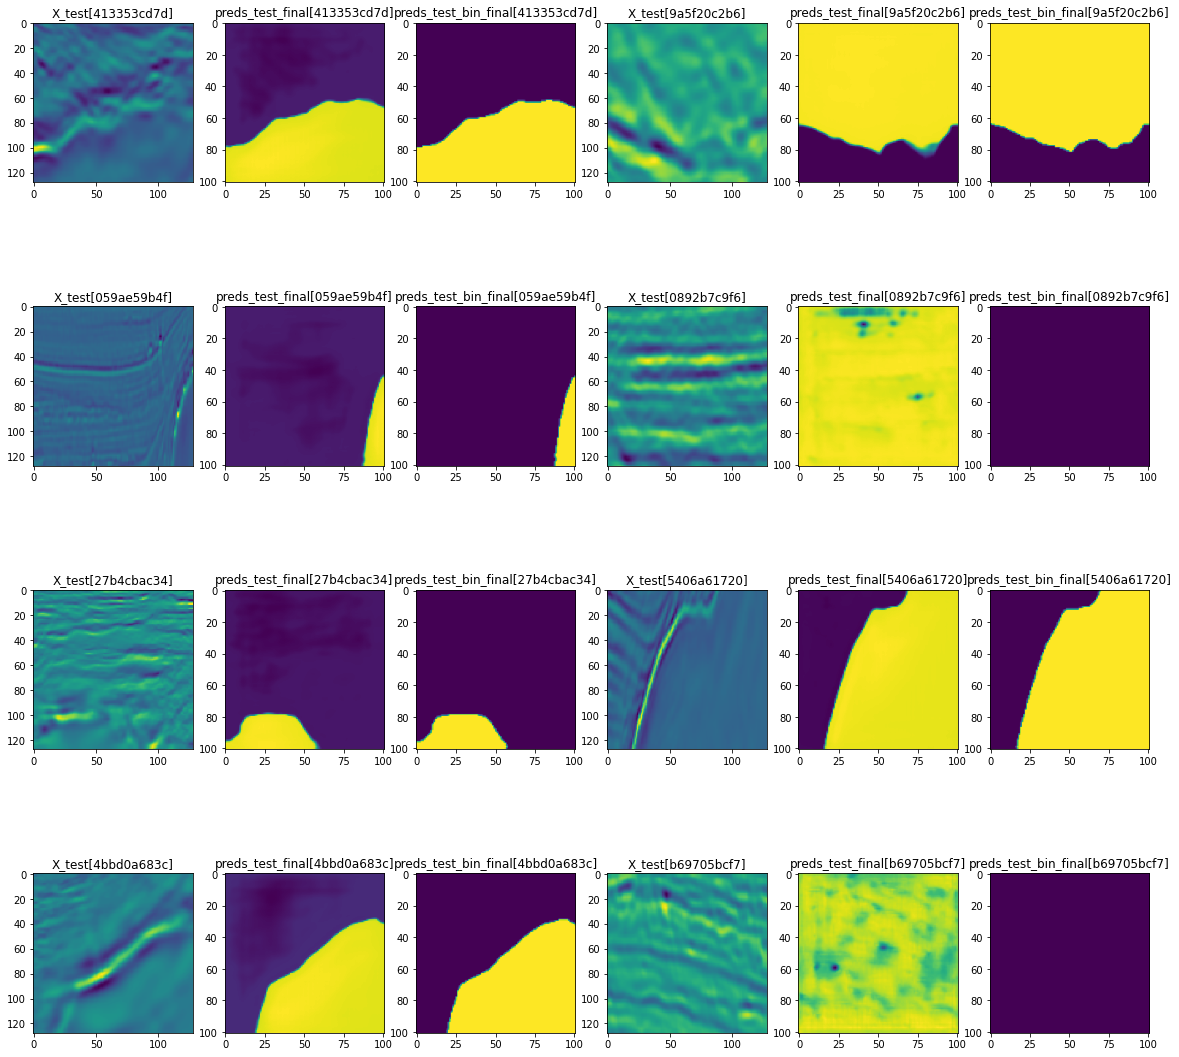

In [29]:
# Plot some predictions of test set
fig = plt.figure(figsize=(20, 20))
for i in range(1, 25, 3):
    idx = random.randint(0, len(X_test))
    filename = test_ids[idx]
    ax1 = plt.subplot(4, 6, i)
    ax1.imshow(X_test[idx])
    ax1.set_title(f'X_test[{filename}]')
    ax2 = plt.subplot(4, 6, i + 1)
    ax2.imshow(preds_test_final[idx])
    ax2.set_title(f'preds_test_final[{filename}]')
    ax3 = plt.subplot(4, 6, i + 2)
    ax3.imshow(preds_test_bin_final[idx])
    ax3.set_title(f'preds_test_bin_final[{filename}]')

# Prepare submission

In [30]:
import more_itertools as mit

def get_submission_format(img, order='F'):
    runs = []
    pixels = img.reshape(img.shape[0] * img.shape[1], order=order)
    if pixels.max() > 0:
        mask_idx = tf.squeeze(tf.where(pixels == 1)) + 1
        try:
            for group in mit.consecutive_groups(mask_idx.numpy()):
                run = list(group)
                runs.append(str(run[0]))
                runs.append(str(len(run)))
            return ' '.join(runs)
        except Exception as e:
            print(e, '-', mask_idx.numpy())
            return ''
    else:
        return ''

# Get submission record
pred_dict = {filename:get_submission_format(img) for filename, img in tqdm(zip(test_ids, preds_test_bin_final))}

0it [00:00, ?it/s]

In [31]:
df = pd.DataFrame.from_dict(pred_dict,orient='index')
df.index.names = ['id']
df.columns = ['rle_mask']
df = df.reset_index()
df

,id,rle_mask
0,5e2a86e209,
1,a4dd1d2900,
2,0681b94208,
3,46bcca523a,1 94 102 94 203 94 304 95 405 100 506 8730 924...
4,981bc36e6e,1 1818 1820 100 1923 98 2025 97 2126 97 2227 9...
...,...,...
17995,0ffbef2a57,50 52 151 52 252 52 353 52 452 54 553 54 653 5...
17996,1b51d7eb4c,1119 12 1220 15 1321 16 1422 19 1516 4 1522 25...
17997,c07ed81d25,1716 1 1814 5 1913 7 2007 14 2102 20 2197 26 2...
17998,802fa1a9f6,5 97 106 97 209 95 314 91 420 86 522 85 624 84...


In [32]:
df.to_csv('resnet_unet_fliplr_batch32_train2_submitOptimize.csv', index=False)